In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

In [26]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [27]:
import tifffile as tiff
import glob
import re
import datetime

In [28]:
patch=99
imgs = tiff.imread('/cloud/s2_europa_test/ROIs1868/142/S2/*/*_patch_'+str(patch)+'.tif')
filenames=glob.glob('/cloud/s2_europa_test/ROIs1868/142/S2/*/*_patch_'+str(patch)+'.tif')


In [29]:

dates=[]
for file in filenames:
    tmp=re.search(r'\d{4}-\d{2}-\d{2}', file)
    dates.append(tmp[0])

sort_dates=sorted(dates, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

#Get sorting indices
sort_ind_dates=[]
for date in sort_dates:
    sort_ind_dates.append(dates.index(date))

#Sort images according to date
imgs_sort=imgs[sort_ind_dates,:,:,:]

#Sort file names
filenames_sort=[]
for sort_ind in sort_ind_dates:
    filenames_sort.append(filenames[sort_ind]) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


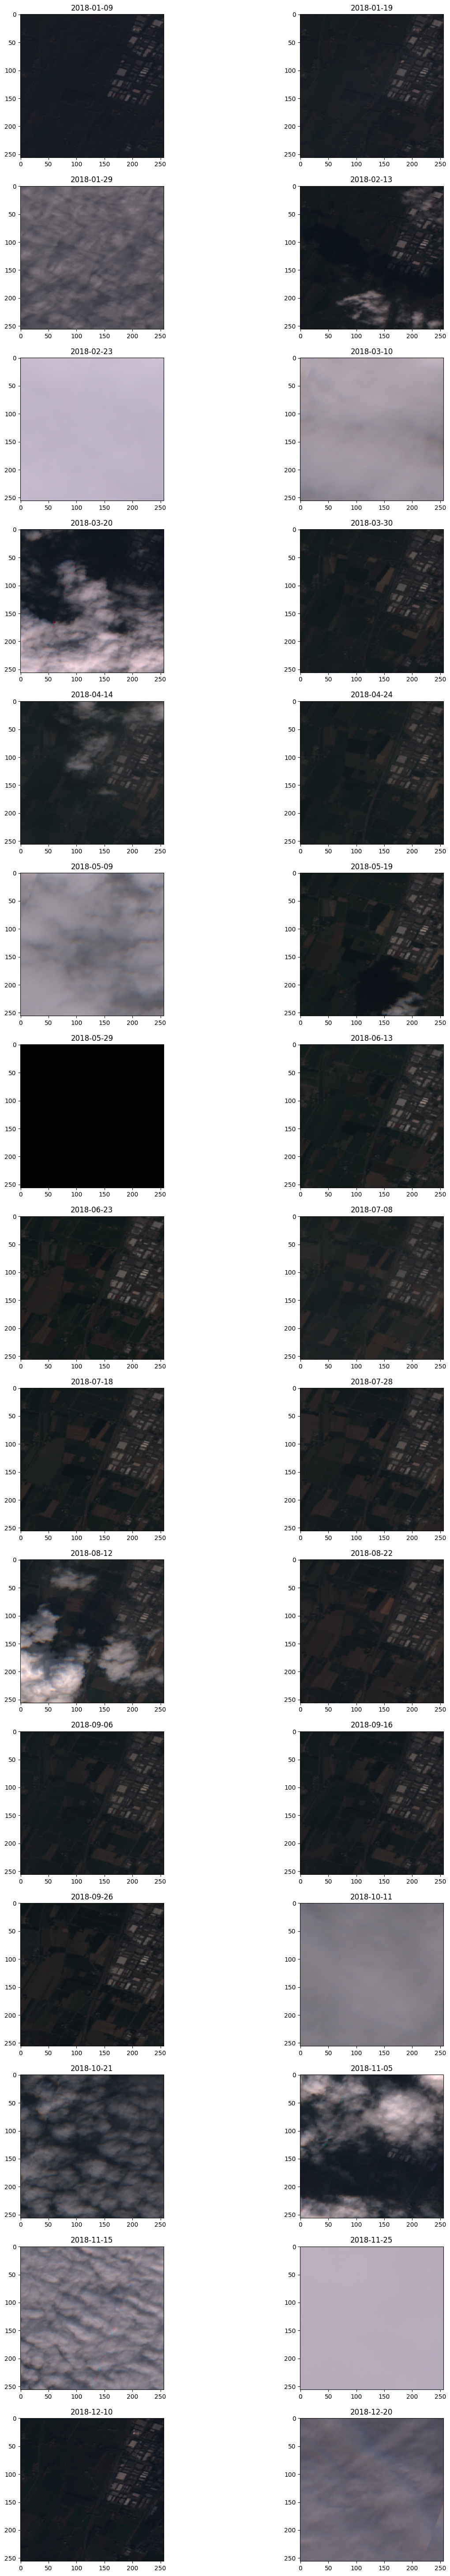

In [30]:
nrows=15
ncols=2
plt.rcParams["figure.figsize"] = [15, 5*nrows]
fig, axs =plt.subplots(nrows=nrows,ncols=ncols)
for i,ax in enumerate(axs.ravel()):
    im=imgs_sort[i,:,:,:]
    ax.imshow(im[:,:,[3,2,1]]/10000)
    ax.set_title(sort_dates[i])

In [31]:
filenames_sort

['/cloud/s2_europa_test/ROIs1868/142/S2/0/s2_ROIs1868_142_ImgNo_0_2018-01-09_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/1/s2_ROIs1868_142_ImgNo_1_2018-01-19_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/2/s2_ROIs1868_142_ImgNo_2_2018-01-29_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/3/s2_ROIs1868_142_ImgNo_3_2018-02-13_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/4/s2_ROIs1868_142_ImgNo_4_2018-02-23_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/5/s2_ROIs1868_142_ImgNo_5_2018-03-10_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/6/s2_ROIs1868_142_ImgNo_6_2018-03-20_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/7/s2_ROIs1868_142_ImgNo_7_2018-03-30_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/8/s2_ROIs1868_142_ImgNo_8_2018-04-14_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/9/s2_ROIs1868_142_ImgNo_9_2018-04-24_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/10/s2_ROIs1868_142_ImgNo_10_2018-05-09_p

In [32]:
img = tiff.imread('/cloud/s2_europa_test/ROIs1868/142/S2/8/s2_ROIs1868_142_ImgNo_8_2018-04-14_patch_99.tif')
img=img/10000


In [33]:
np.shape(img)

(256, 256, 13)

Text(0.5, 1.0, 'Example image with RGB channel (4,3,2)')

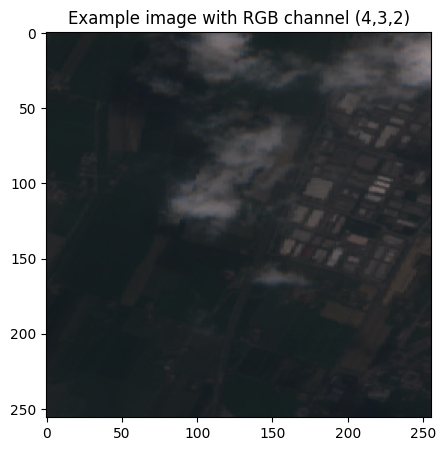

In [34]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(img[:,:,[3,2,1]])
plt.title("Example image with RGB channel (4,3,2)")

In [35]:
img_11=img[:,:,11]
img_11_flat=np.array([j for sub in img_11 for j in sub])

Text(0.5, 1.0, 'Example image with band 11')

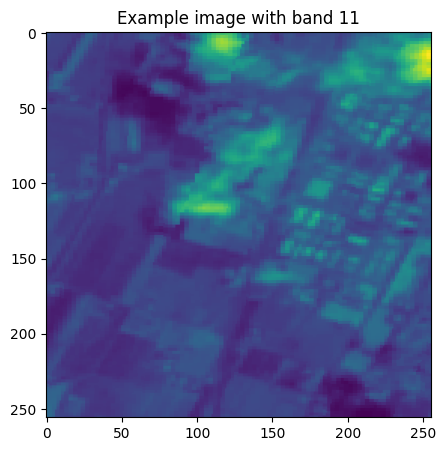

In [36]:
plt.imshow(img[:,:,11])
plt.title("Example image with band 11")

In [37]:
main_filepath='pytorch_models/cont_test'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

X_test=pd.read_csv(main_filepath+'/xtest.csv',index_col=0)
y_test=pd.read_csv(main_filepath+'/ytest.csv',index_col=0)

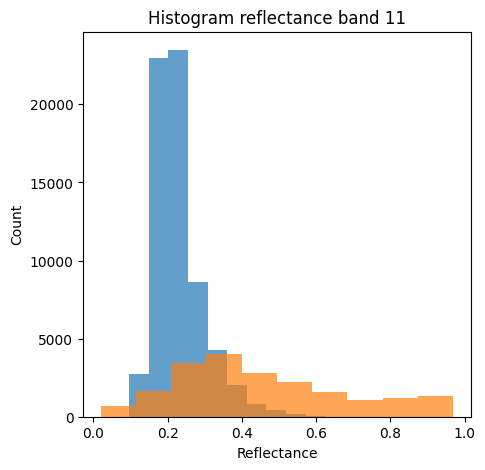

In [38]:

plt.hist(img_11_flat,alpha=0.7)
plt.hist(y_test.to_numpy()[:,11],alpha=0.7)
plt.title("Histogram reflectance band 11")
plt.xlabel("Reflectance")
plt.ylabel("Count")
plt.show()

In [39]:
#Reshape input image to correct form
img_12_bands=img[:,:,1:]
image_shape=np.shape(img_12_bands)
image_input=np.reshape(img_12_bands,(image_shape[0]*image_shape[1],image_shape[2]))

#Predict
for i,model in enumerate(models):
    if i==0:
        y_pred=model.predict(image_input)
    else:   
        y_pred=y_pred+model.predict(image_input)
y_pred=y_pred/len(models)

img_pred=y_pred[:,:,1] # Get median quantile

#Reshape output prediction
img_pred_reshape=np.reshape(img_pred,(image_shape[0],image_shape[1],image_shape[2]))


Text(0.5, 1.0, 'Example reconstruction band 11')

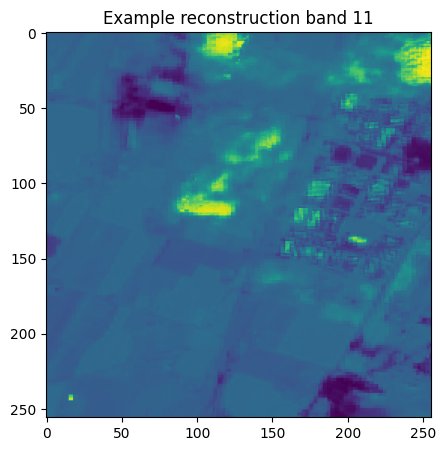

In [40]:
plt.imshow(img_pred_reshape[:,:,10])
plt.title("Example reconstruction band 11")

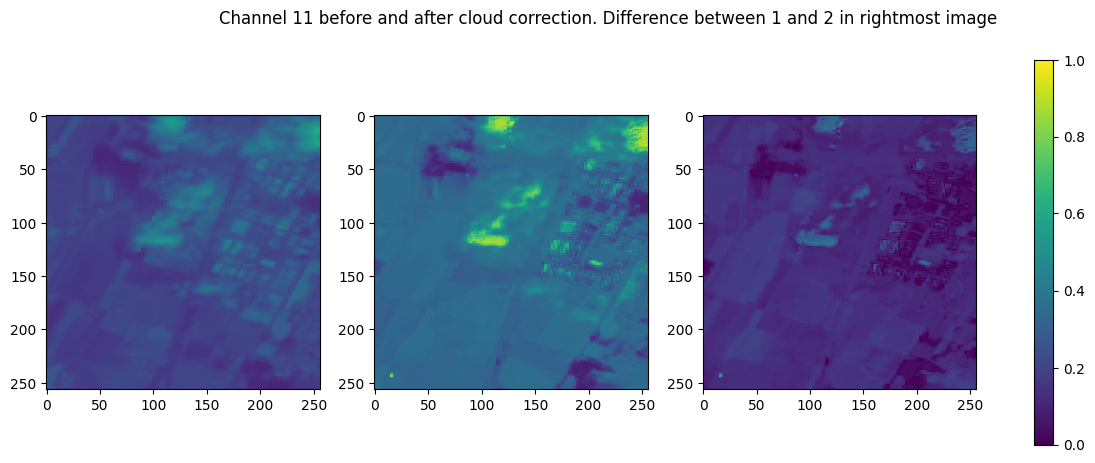

In [41]:
plt.rcParams["figure.figsize"] = [15, 5]
fig, axs =plt.subplots(nrows=1,ncols=3)
fig.suptitle("Channel 11 before and after cloud correction. Difference between 1 and 2 in rightmost image")

im1=axs[0].imshow(img[:,:,11],vmin=0,vmax=1)
im2=axs[1].imshow(img_pred_reshape[:,:,10],vmin=0,vmax=1)
im3=axs[2].imshow(np.abs((img[:,:,11])-(img_pred_reshape[:,:,10])),vmin=0,vmax=1)
fig.colorbar(im1,ax=axs.ravel().tolist())



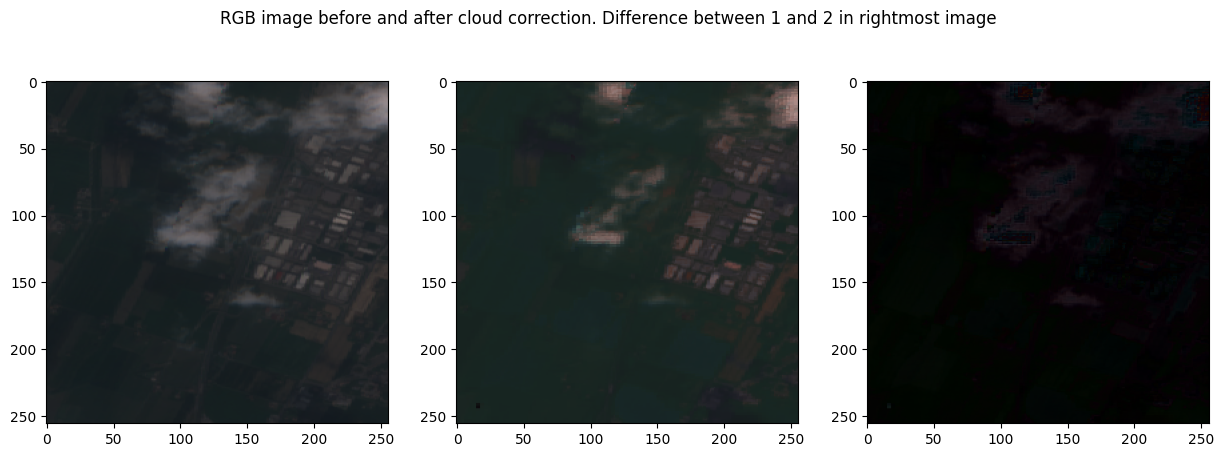

In [42]:
fig, axs =plt.subplots(nrows=1,ncols=3)
fig.suptitle("RGB image before and after cloud correction. Difference between 1 and 2 in rightmost image")

axs[0].imshow(img[:,:,[3,2,1]])
axs[1].imshow(img_pred_reshape[:,:,[2,1,0]])
axs[2].imshow(np.abs((img[:,:,[3,2,1]])-(img_pred_reshape[:,:,[2,1,0]])))

In [43]:
#Get quantiles of prediction

pred_quant_01=y_pred[:,:,0]
pred_quant_09=y_pred[:,:,2]

img_pred_01=np.reshape(pred_quant_01,(image_shape[0],image_shape[1],image_shape[2]))
img_pred_09=np.reshape(pred_quant_09,(image_shape[0],image_shape[1],image_shape[2]))
# Get uncertainty image
pred_uncertainty=img_pred_09-img_pred_01

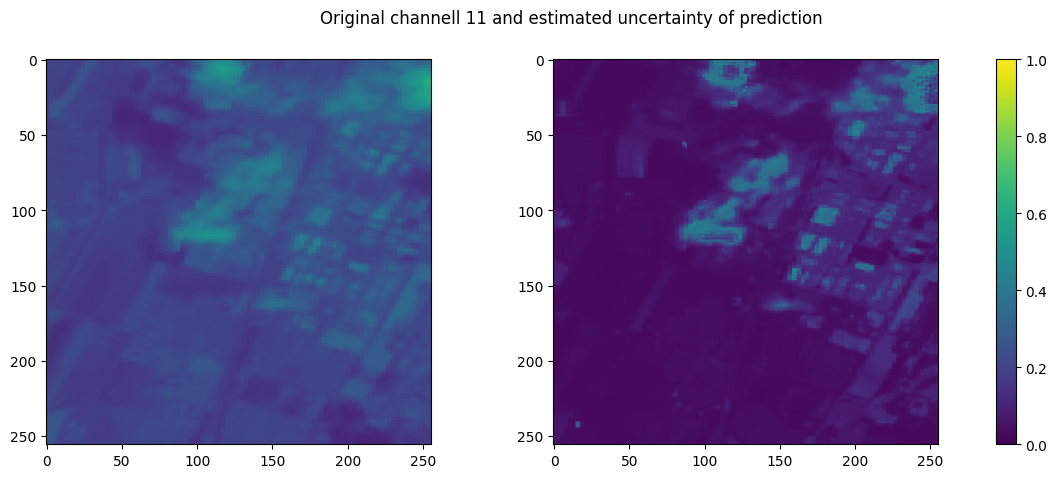

In [44]:
fig,axs=plt.subplots(nrows=1,ncols=2)
fig.suptitle("Original channell 11 and estimated uncertainty of prediction")
im1=axs[0].imshow(img[:,:,11],vmin=0,vmax=1)
axs[1].imshow(pred_uncertainty[:,:,10],vmin=0,vmax=1)
fig.colorbar(im1,ax=axs.ravel().tolist())

## Load COT estimator

In [45]:
from cot_train.utils import StatCollector, MLP5

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
SKIP_BAND_1=1
PROPERTY_COLUMN_MAPPING = {'spec_bands': [i for i in range(1 + SKIP_BAND_1, 14)], 'angles': [14, 15, 16], 'thick': [17], 'type': [18], 'prof_id': [19], 'gas_vapour': [20, 21], 'surf_prof': [22]}
INPUTS = ['spec_bands']
REGRESSOR = 'thick'

input_dim = np.sum([len(PROPERTY_COLUMN_MAPPING[inp]) for inp in INPUTS])
output_dim = 1

model_load_path='holy_cot_estimations/2024-03-11_12-44-40/model_it_2000000'
model_cot = MLP5(input_dim, output_dim, apply_relu=True)
model_cot.load_state_dict(torch.load(model_load_path))

<All keys matched successfully>

In [92]:
means_input_train = np.mean(image_input, axis=0)
stds_input_train = np.std(image_input, axis=0)
inputs = (image_input - means_input_train) / stds_input_train


image_input_tens=torch.Tensor(inputs).to(device)
image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50

In [93]:
image_pred_cot_reshape=np.reshape(image_pred_cot,(image_shape[0],image_shape[1]))

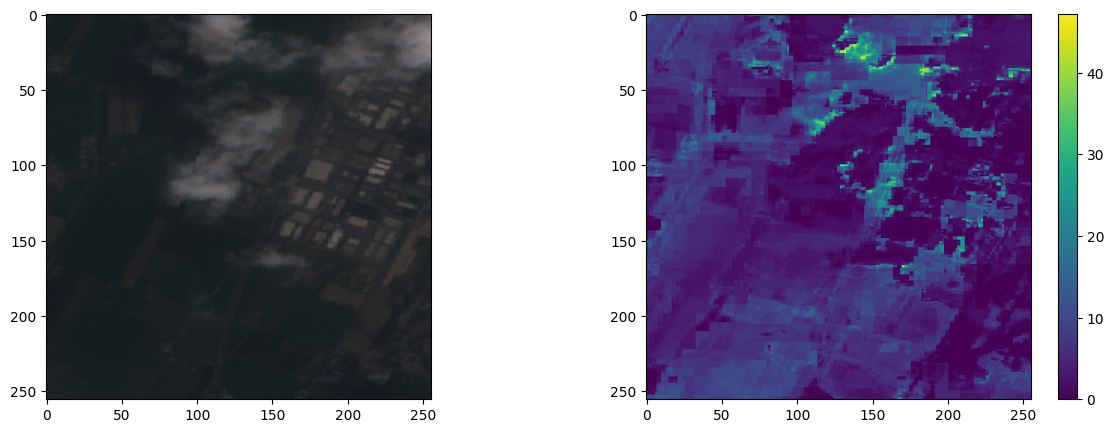

In [94]:
fig,axs=plt.subplots(nrows=1,ncols=2)
axs[0].imshow(img[:,:,[3,2,1]])
im=axs[1].imshow(image_pred_cot_reshape)
fig.colorbar(im,ax=axs[1])

## Concat many many images

In [42]:
imgs = tiff.imread('/cloud/s2_europa_test/ROIs1868/142/S2/0/*'+'.tif')
filenames=glob.glob('/cloud/s2_europa_test/ROIs1868/142/S2/0/*'+'.tif')

In [43]:
imgs_shape=np.shape(imgs)
images_flat=np.zeros((imgs_shape[1]*imgs_shape[2],imgs_shape[3]))
for i in range(imgs_shape[0]):
    tmp_im=imgs[i,:,:,:]
    tmp_im_reshape=np.reshape(tmp_im,(imgs_shape[1]*imgs_shape[2],imgs_shape[3]))
    print(i)
    if i==0:
        images_flat[:]=tmp_im_reshape
    else:
        images_flat=np.append(images_flat,tmp_im_reshape,axis=0)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296

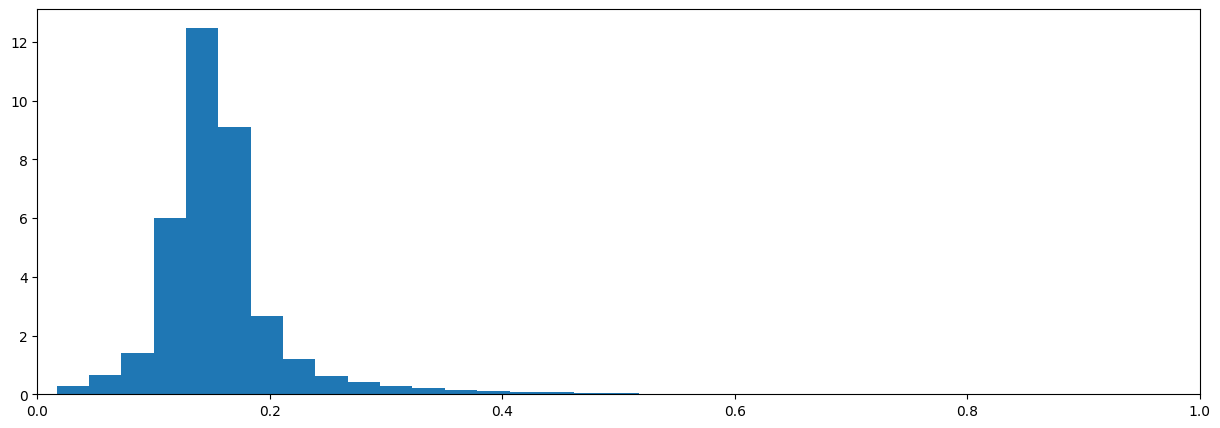

In [49]:
plt.hist(images_flat[:,11]/10000,bins=100,density=True)
plt.xlim((0,1))
plt.show()